### Imports

In [1]:
import pandas as pd
import reciprocalspaceship as rs
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import r2_score
import numpy as np
import json
from scipy import stats
import random
from keras import backend as K_backend
import math
import gemmi
from sklearn.decomposition import PCA
import time
import sys
from scipy.stats import pearsonr
import pickle
from tqdm import tqdm

### Ligand CIF Processing

In [2]:
ligand_cif = []

with open('../PTP1B_DK/ligand_cif_to_dataset_mapping.txt') as f:
    lines = f.readlines()
    
for line in lines:
    dataset, ligands = line[:-1].split(":")
    ligands = list(filter(None,ligands.split(" ")))
    ligand_cif.append([dataset, ligands, 0 if len(ligands) > 0 else 1])
    
ligand_cif = pd.DataFrame(ligand_cif, columns=["Dataset", "Ligands", "Apo"])

apo_samples = ligand_cif[ligand_cif['Apo'] == 1]['Dataset'].tolist()
apo_samples = [sample.split('y')[1] for sample in apo_samples]

samples = ligand_cif['Dataset'].tolist()
samples = [sample.split('y')[1] for sample in samples]

### Scaling

In [3]:
def dwl_vector(k, L_diag, L_lt, F2, H, K, L, cell):
    
    U = L_diag + L_lt + tf.transpose(L_lt)
        
    inner_calculation = U[0][0]*cell.a**2*(H**2) + U[1][1]*cell.b**2*(K**2) + U[2][2]*cell.c**2*(L**2)
    inner_calculation += 2*U[0][1]*H*K*cell.a*cell.b*np.cos(np.deg2rad(cell.gamma))
    inner_calculation += 2*U[0][2]*H*L*cell.a*cell.c*np.cos(np.deg2rad(cell.beta))
    inner_calculation += 2*U[1][2]*K*L*cell.b*cell.c*np.cos(np.deg2rad(cell.alpha))

    pred = k * tf.exp(-2*(np.pi**2)*inner_calculation) * F2
    return pred

In [4]:
def train_vector(F_obs_unscaled, F_obs, n_iter, lr, cell, H, K, L, convergence_constraint=0.001):    
 
    # Initialize parameters
    k = tf.Variable(1.1, name="k", dtype=tf.float32)
    A = tf.constant([[0.5, 1.2, -1.1],[0.8, 0.2, -1.4],[0.0, 0.2, -0.5]], dtype=tf.float32)
    # shape [3,] vector
    L_diag = tf.Variable(tf.linalg.diag_part(A), name='L_diag', dtype=tf.float32)
    # shape [3,3] matrix with nonzero lower triangular elements
    L_lt = tf.Variable(tf.linalg.band_part(A, -1, 0)-tf.linalg.band_part(A, 0, 0), name='L_lt', dtype=tf.float32) 

    # convert data to tensors
    F1 = list(F_obs.values)
    F2 = list(F_obs_unscaled.values)
    H = list(H.values)
    K = list(K.values)
    L = list(L.values)

    F1 = tf.constant(F1, dtype=tf.float32)
    F2 = tf.constant(F2, dtype=tf.float32)
    H = tf.constant(H, dtype=tf.float32)
    K = tf.constant(K, dtype=tf.float32)
    L = tf.constant(L, dtype=tf.float32)
        
    def loss_function(k, L_diag, L_lt, F1, F2, H, K, L):
        pred = dwl_vector(k, L_diag, L_lt, F2, H, K, L, cell)
        sum_error = tf.reduce_sum((pred - F1) ** 2)/tf.reduce_sum(pred**2)
        return sum_error
    
    # steptrain function
    @tf.function()
    def steptrain(optimizer):
        with tf.GradientTape() as tape:
            loss = loss_function(k, L_diag, L_lt, F1, F2, H, K, L)
        grads = tape.gradient(loss, [k, L_diag, L_lt])
        optimizer.apply_gradients(zip(grads, [k, L_diag, L_lt]))
        return loss
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    loss_record = []
    for i in range(n_iter):
        loss_record.append(steptrain(optimizer))
    
    times = 0
    lr_change = lr
    cur = True
    
    while (np.max(abs(loss_record[-n_iter:] - loss_record[-1])) > convergence_constraint):
        times += 1
        for i in range(n_iter):
            loss_record.append(steptrain(optimizer))
    
    return float(k), L_diag.numpy(), L_lt.numpy(), loss_record, times

In [8]:
!cp ../PTP1B_DK/mtzs/PTP1B-y0001_mrflagsref_idxs.mtz ../PTP1B_DK/scaled_vector_mtzs/PTP1B-y0001_mrflagsref_idxs_scaled.mtz

In [3]:
base = rs.read_mtz(f'../PTP1B_DK/scaled_vector_mtzs/PTP1B-y{samples[0]}_mrflagsref_idxs_scaled.mtz')
base['F-obs-scaled'] = base['F-obs']
base.write_mtz(f'../PTP1B_DK/scaled_vector_mtzs/PTP1B-y{samples[0]}_mrflagsref_idxs_scaled.mtz')

In [5]:
scaling_data = {}
for sample in samples[1600:]:
        
    # currently just scaling to the first mtz file
    base = rs.read_mtz(f'../PTP1B_DK/mtzs_reindex/PTP1B-y{samples[0]}_mrflagsref_idxs.mtz')[['F-obs', 'SIGF-obs']]
    
    # file not found error
    try: 
        pre_scale = rs.read_mtz(f'../PTP1B_DK/mtzs_reindex/PTP1B-y{sample}_mrflagsref_idxs.mtz')
        
    except:
        continue

    # determining k and B by comparing to the base
    base = base.merge(pre_scale, left_index=True, right_index=True, suffixes=(f'_{samples[0]}', f'_{sample}'), check_isomorphous=False)

    base = base.reset_index()
    pre_scale = pre_scale.reset_index()
    
    cell = pre_scale.cell.reciprocal()
    
    k, L_diag, L_lt, loss_record, times = train_vector(base[f'F-obs_{sample}'], base[f'F-obs_{samples[0]}'], 500, 0.001, cell=cell, H=base['H'], K=base['K'], L=base['L'])
    
    scaling_data[sample] = {'loss_record': [float(x) for x in loss_record], 'k': k, 'L_diag': L_diag, 'L_lt': L_lt}

    # adding the column to the pre_scale
    pre_scale['F-obs-scaled'] = rs.DataSeries(dwl_vector(k, L_diag, L_lt, pre_scale['F-obs'], H=pre_scale['H'], K=pre_scale['K'], L=pre_scale['L'], cell=cell), dtype="SFAmplitude")
    pre_scale = pre_scale.set_index(['H', 'K', 'L'])
    
    pre_scale.write_mtz(f'../PTP1B_DK/scaled_vector_mtzs/PTP1B-y{sample}_mrflagsref_idxs_scaled.mtz')
    
    base = base.set_index(['H', 'K', 'L'])
    merged = base.merge(pre_scale, left_index=True, right_index=True, suffixes=(f'_{samples[0]}', f'_{sample}'), check_isomorphous=False)

    corr_1 = np.corrcoef(merged[f'F-obs_{samples[0]}'], merged[f'F-obs_{sample}'])[0][1]
    corr_2 = np.corrcoef(merged[f'F-obs_{samples[0]}'], merged[f'F-obs-scaled'])[0][1]

    print('unscaled:', corr_1, 'scaled:', corr_2)
                                              
with open('../PTP1B_DK/scaling_data/scaled_vectors_mtzs/scaling_parameters.json', 'w') as fp:
    json.dump(scaling_data, fp)

ERROR! Session/line number was not unique in database. History logging moved to new session 434
unscaled: 0.993302303195387 scaled: 0.9935219072710049
unscaled: 0.9947304987005928 scaled: 0.9944831036492129
unscaled: 0.9602709755531997 scaled: 0.9727313839488665
unscaled: 0.9968961960046985 scaled: 0.9969233905029924
unscaled: 0.9962921540313718 scaled: 0.9964409419822594
unscaled: 0.9962706403172612 scaled: 0.9964201762884499
unscaled: 0.9822631297178923 scaled: 0.9839870255099155
unscaled: 0.8800277264054648 scaled: 0.8747324110021505
unscaled: 0.990614400742853 scaled: 0.9920696175334162
unscaled: 0.9910405854106362 scaled: 0.991378617387838
unscaled: 0.9917154378630572 scaled: 0.9935022270877764
unscaled: 0.9966770770120731 scaled: 0.9972143758913151
unscaled: 0.9774589670448403 scaled: 0.9777746802999039
unscaled: 0.9964631294531046 scaled: 0.996548844522342
unscaled: 0.8848652796924776 scaled: 0.8744638863308339
unscaled: 0.9536279003099764 scaled: 0.9529824701201933
unscaled: 0.

FileNotFoundError: [Errno 2] No such file or directory: './PTP1B_DK/scaling_data/scaled_vectors_mtzs/scaling_parameters.json'

### PCA (Intersection)

In [4]:
# write to a file for the intersections of all files
F1 = rs.read_mtz(f'../PTP1B_DK/scaled_vector_mtzs/PTP1B-y0001_mrflagsref_idxs_scaled.mtz')[['F-obs']]
F1 = F1.rename(columns={'F-obs': 'F-obs-scaled_0001'})
for i in tqdm(samples):
        
    try: 
        F2 = rs.read_mtz(f'../PTP1B_DK/scaled_vector_mtzs/PTP1B-y{i}_mrflagsref_idxs_scaled.mtz')[['F-obs-scaled']]
        F2 = F2.rename(columns={'F-obs-scaled': f'F-obs-scaled_{i}'})
        
    except:
        continue
                
    F1 = F1.merge(F2, left_index=True, right_index=True, check_isomorphous=False)
    
F1.write_mtz(f'../PTP1B_DK/scaled_vector_mtzs/intersection.mtz')

100%|██████████| 1958/1958 [08:25<00:00,  3.87it/s]
/n/home10/phyllis/mambaforge/envs/rs/lib/python3.7/site-packages/reciprocalspaceship/dataset.py:296: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset = super().reset_index(level, drop=drop, inplace=inplace, col_level=col_level, col_fill=col_fill)


/n/home10/phyllis/mambaforge/envs/rs/lib/python3.7/site-packages/reciprocalspaceship/io/mtz.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[c.label] = c.array
/n/home10/phyllis/mambaforge/envs/rs/lib/python3.7/site-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


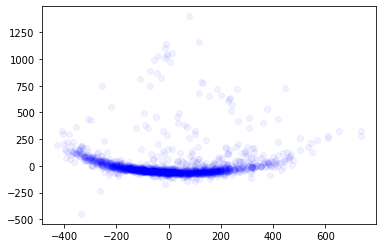

In [5]:
intersection = rs.read_mtz('../PTP1B_DK/scaled_vector_mtzs/intersection.mtz')
pca = PCA()
principalComponents = pca.fit_transform(intersection.T)
principalDf = pd.DataFrame(data = principalComponents)
plt.scatter(principalDf[[0]], principalDf[[1]], c='blue', alpha=0.05)
plt.show()

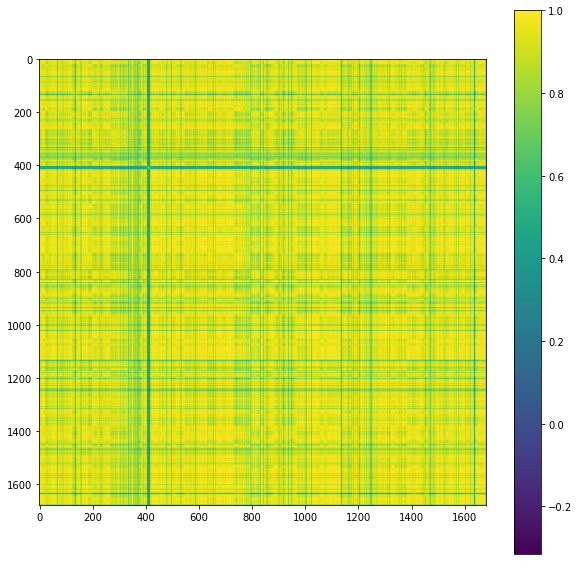

In [7]:
plt.figure(figsize=(10, 10))
plt.imshow(intersection.corr().to_numpy())
plt.colorbar()
plt.show()

### Union

In [7]:
# write to a file for the union of all files
F1 = rs.read_mtz(f'../PTP1B_DK/scaled_vector_mtzs/PTP1B-y0001_mrflagsref_idxs_scaled.mtz')[['F-obs']]
F1 = F1.rename(columns={'F-obs': 'F-obs-scaled_0001'})
for i in tqdm(samples):
        
    try: 
        F2 = rs.read_mtz(f'../PTP1B_DK/scaled_vector_mtzs/PTP1B-y{i}_mrflagsref_idxs_scaled.mtz')[['F-obs-scaled']]
        F2 = F2.rename(columns={'F-obs-scaled': f'F-obs-scaled_{i}'})
        
    except:
        continue
                
    F1 = F1.merge(F2, left_index=True, right_index=True, how='outer', check_isomorphous=False)
    
F1.write_mtz(f'../PTP1B_DK/scaled_vector_mtzs/union.mtz')

100%|██████████| 1958/1958 [26:34<00:00,  1.23it/s]
/n/home10/phyllis/mambaforge/envs/rs/lib/python3.7/site-packages/reciprocalspaceship/dataset.py:296: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset = super().reset_index(level, drop=drop, inplace=inplace, col_level=col_level, col_fill=col_fill)


In [8]:
F1

F-obs-scaled_0001  F-obs-scaled_0002  F-obs-scaled_0003  \
H  K L                                                             
0  0 3                 NaN          233.28981          264.69904   
     6               134.2          171.29752                NaN   
     9               84.87          73.300446                NaN   
     12               55.4           64.18847                NaN   
     15              71.83          78.071884                NaN   
...                    ...                ...                ...   
51 0 4                 NaN                NaN                NaN   
     5                 NaN                NaN                NaN   
     6                 NaN                NaN                NaN   
     7                 NaN                NaN                NaN   
     8                 NaN                NaN                NaN   

         F-obs-scaled_0004  F-obs-scaled_0006  F-obs-scaled_0009  \
H  K L                                                             
0  0 3            268.4055          155.14444          145.44363   
     6           160.82661                NaN          145.66516   
     9           62.922756                NaN          81.702415   
     12          57.034027                NaN          63.084118   
     15           70.79693                NaN            69.0996   
...                    ...                ...                ...   
51 0 4                 NaN                NaN                NaN   
     5                 NaN                NaN                NaN   
     6                 NaN                NaN                NaN   
     7                 NaN                NaN                NaN   
     8                 NaN                NaN                NaN   

         F-obs-scaled_0010  F-obs-scaled_0011  F-obs-scaled_0012  \
H  K L                                                             
0  0 3            204.0502          216.13223          161.46832   
     6            140.9534                NaN          148.96985   
     9            92.95826                NaN           89.14393   
     12          52.850224                NaN          56.783443   
     15           60.94351           68.43774          62.208355   
...                    ...                ...                ...   
51 0 4                 NaN                NaN                NaN   
     5                 NaN                NaN                NaN   
     6                 NaN                NaN                NaN   
     7                 NaN                NaN                NaN   
     8                 NaN                NaN                NaN   

         F-obs-scaled_0013  ...  F-obs-scaled_1955  F-obs-scaled_1956  \
H  K L                      ...                                         
0  0 3           163.98038  ...          232.93633                NaN   
     6             155.065  ...          146.35599           149.2227   
     9           86.404655  ...          85.536385           90.14671   
     12           57.23095  ...          55.642406           53.90476   
     15          72.455345  ...           71.69722           69.17753   
...                    ...  ...                ...                ...   
51 0 4                 NaN  ...                NaN                NaN   
     5                 NaN  ...                NaN                NaN   
     6                 NaN  ...                NaN                NaN   
     7                 NaN  ...                NaN                NaN   
     8                 NaN  ...                NaN                NaN   

         F-obs-scaled_1957  F-obs-scaled_1958  F-obs-scaled_1959  \
H  K L                                                             
0  0 3                 NaN          240.48619                NaN   
     6           156.18695          176.00505           161.1973   
     9            80.00077            74.9272          79.857376   
     12          61.445896          62.088024          58.007286